<a href="https://colab.research.google.com/github/huskeypm/cellmigration/blob/main/expt_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exptl analysis
Last ran on colab, 240311

This notebook
* loads tif files from a migration experiment,
* uses trackpy to find moving cells, and
* fits a linear equation to their mean square displacements to obtain a diffusion coefficient.

Data
* My input data is currently located at
/content/drive/MyDrive/public/
which is mounted to google drive.
* This path will need to be adjusted if data are stored elsewhere

Usage:
* Copy files of interest to an appropriate google drive directory
(current set is from Emily's Feb collections)
* run the first part of the code to completion and **modify the default parameters** to work with your data
* once the right parameters are determined, process your remaining files; a csv file should result for each input file

To analyze
* Use second part of notebook to load in csv files and plot

Install needed packages



In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!pip3 install pims trackpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pims: filename=PIMS-0.6.1-py3-none-any.whl size=82615 sha256=4843fd6fff0373b8fdbc65abb1f2ed34a9cca44f189cf86f9b13f14f33be6b8a
  Stored in directory: /root/.cache/pip/wheels/cc/bf/3e/bfa77232d942f8244145f9c713b6b38f6ef04b6fb5c021c114
  Created wheel for trackpy: filename=trackpy-0.6.2-py3-none-any.whl size=130035 sha256=ed567811694e44c559dd3c7a966227a02ac18ac15f01048cd7675769fb1b6e0d
  Stored in directory: /root/.cache/pip/wheels/5f/9a/2f/ad3db472b01ad7848e38e89b0b2fabd4e8fc14d8a499d10e06
Successfully built pims trackpy


Check out cellmigration github repo

In [4]:
!git clone https://github.com/huskeypm/cellmigration.git
#!cd cellmigration; git pull

fatal: destination path 'cellmigration' already exists and is not an empty directory.


In [5]:
import sys
sys.path.append("cellmigration")

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import pims
import trackpy as tp
import tifffile

import expt_analysis.trackcells as tc

# Process raw images
## Image processing

Define inputs (pretty much the only places needed for making changes)

In [59]:
!ls /content/cellmigration

batchProcess.py    concentration.py	      LICENSE		     README_1.md
brownian_v2.py	   conda_openmm_pytraj.ipynb  master.ipynb	     README.md
brownian_v3.py	   config.bash		      migration_paper.ipynb  run
brownian_v4.py	   cont_analysis	      paper		     states.py
brownian_v5.py	   expt_analysis	      parameters.py	     TAM_example.ipynb
brown_util.py	   expt_analysis.ipynb	      pdb.py		     tests
brown_wnonbond.py  histo.ipynb		      processData.py	     update.py
calculator.py	   lattice.py		      processYaml.py	     validation.py


In [60]:
# read in image and show first frame
user = "Emily"
user = "PKH"
useGdrive = False
if user == "Emily":
  name='Position4'
  fileName=r"C:\Users\ekrue\Downloads\12_13_23_{}.tif".format(name)
elif user == "PKH":
  name = "Position_1" #
  #name = "Position_3"
  gpath=('/content/drive')
  path=gpath+"/MyDrive/public/"
  fileName = path+"/%s_movie.tif"%name
  useGdrive=True
  sourcePath = "/content/cellmigration/"
#
#  Parameters to edit
#
# time/frame conversion
fr = 180 # s/fr # experiment

# image processing parameters (disable downsample and crop for full analyses )
downsampleRate = 4
crop=True
thresh=True


# determine parameters to track particles
# paramters: diameter, minmass
#- positiion 1
diameter=101  # adjust me first
minmass = 20000
#- positiion 2
#diameter=91  # adjust me first
#minmass = 100
#- positiion 3
#diameter=101  # adjust me first
#minmass = 1000


# for fitting MSDs
fittingRange=[0,100]



Read images

Mount google drive.
I added a shortcut to a shared tif file in my 'public' directory

 /content/drive/MyDrive/public/

In [9]:
if useGdrive:
  from google.colab import drive
  drive.mount(gpath)

Mounted at /content/drive


(480, 1200, 1200)


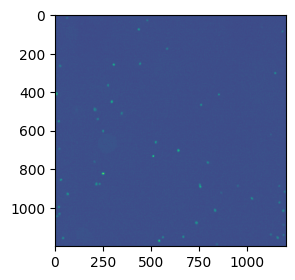

In [16]:
# read image
raw_data = tifffile.imread(fileName)
print(raw_data.shape)

multiChannel = False
if multiChannel:
  channel=0
  frames=raw_data[:,channel,:,:]
else:
  frames=raw_data[:,:,:]

plt.imshow(frames[0,:,:])


(120, 300, 300)


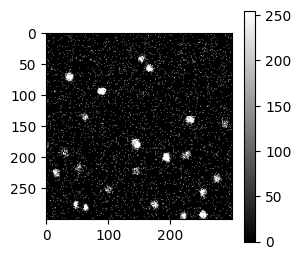

In [17]:
threshed = tc.ProcessFrames(frames,downsampleRate=downsampleRate,crop=crop,thresh=thresh)


### Tracking

* If cells aren't detecting, reduce diameter/minmass or both.
* The displayed mass histogram can help with this optimization

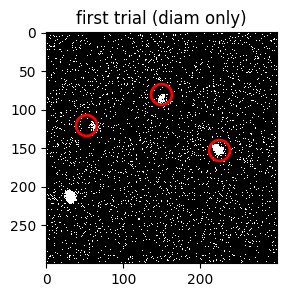

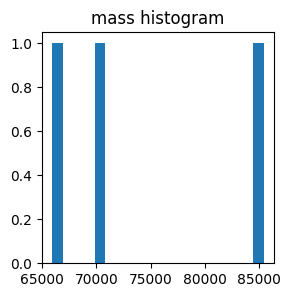

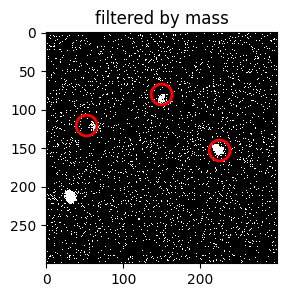

In [20]:
dummy = tc.TrialParams(threshed,refFrame=0,diameter=diameter,minmass=minmass)
if dummy.shape[0] <1:
  print("Error finding cells; try different parameters")
else:
  finalStack = threshed


In [21]:
# run batch/tracking
fb=tc.DoTracking(finalStack,diameter=diameter,minmass=minmass)

try:
  print("shape final %d"%fb.shape[0])
except:
  print("Unsuccessful tracking")

fb

Frame 119: 2 features
shape final 206


,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,79.679445,148.986987,70492.226200,30.434149,0.156832,237.633204,133365.0,NaN,0
1,120.114218,51.210056,65912.374060,30.545708,0.258942,226.672892,120870.0,NaN,0
2,152.741280,224.539410,85463.426719,26.341145,0.123477,236.997665,159885.0,NaN,0
3,60.522168,172.513164,62646.313573,28.807576,0.072981,239.868162,111435.0,NaN,1
4,120.847977,69.360427,59556.350652,29.619711,0.102658,228.896315,107610.0,NaN,1
...,...,...,...,...,...,...,...,...,...
201,181.753359,177.071823,95817.042475,26.878223,0.585488,238.996350,152235.0,NaN,117
202,150.350822,242.380889,86830.754987,32.521799,0.183707,241.987741,132345.0,NaN,118
203,181.660315,135.621320,68532.272321,24.446457,0.128579,241.961894,113730.0,NaN,118
204,52.793055,159.523895,73281.055992,25.276185,0.335163,241.926082,122655.0,NaN,119


### MSD analyses

<font color=red>WARNING: the msd plot needs to be rescaled according to correct spatial and temporal units</font>

Frame 119: 2 trajectories present.
Found 206 
Retained 178 particles
Drift 
                 y           x
frame                        
1        7.658605   11.316205
2        6.921679    8.162204
3        9.832229   17.426062
4        1.605819   31.490257
5        7.906129   20.668769
...           ...         ...
115   -161.859135 -175.947285
116   -171.787271 -178.891063
117   -163.447401 -203.617343
118   -163.540445 -245.067846
119   -153.332514 -220.795632

[96 rows x 2 columns]


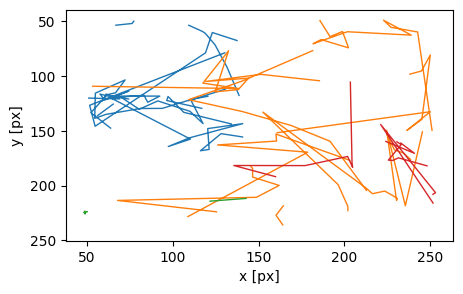

Double check, data contains ALL particle trajectories? (%d)
slope/intercept [3.33126741e+00 7.99092114e+03]


<Figure size 500x300 with 0 Axes>

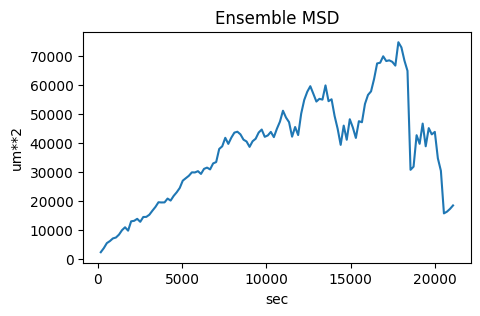

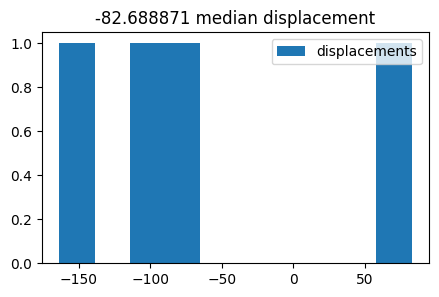

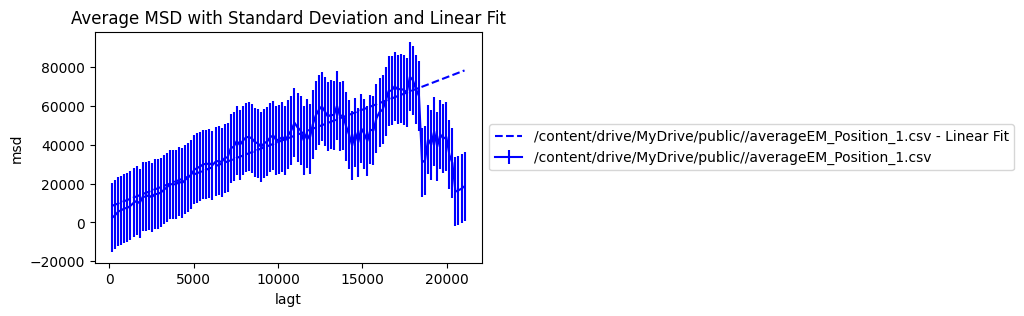

In [22]:

# compute MSD
ts,traj,msd,im,em=tc.DoMSD(
    fb,
    maxDist=100, # maximum displacement between frames in pixel
    maxMissFrame=10, # allowed number of frames a particle can disappear
    minFrame=10, # minimum number of frames a trajectory needs to last
    pixelSize=1.1, # image pixel size in micron/pixel, specific for each scope and lens (Cytiva 10X: 0.65) and (Spinning Disk: 1.1 at 10X)
    frameRate=1/fr, # image acquisition rate in frames/sec
    max_lagtime=160, # intervals of frames out to which MSD is computed
    name=name
)

# get displacements
dists, xdists = tc.CalcDistances(traj) # performed on trajectories BEFORE drift-correction
med = np.median(xdists)
plt.figure()
plt.title("%f median displacement"%med)
plt.hist(xdists,label="displacements")
plt.legend(loc=0)

# save average MSD for each run to csv file
msdFileName=path+'/averageEM_{}.csv'.format(name)
diffFileName=path+'/diff_{}.csv'.format(name)
if name is not None:
    em.to_csv(msdFileName)
    np.savetxt(diffFileName,np.array(xdists))
    # prompt: save pandas dataframe
    traj.to_csv(path+'/traj_{}.csv'.format(name))
    fb.to_csv(path+'/fbframe_{}.csv'.format(name))

msdFile={
    path+'/averageEM_{}.csv'.format(name):{"color":"blue"}
}
plt.figure()
tc.doMSDFit(msdFile, fittingRange=fittingRange)



# Post processing

Create list of names

slope/intercept [2.89013214e+00 5.16961257e+03]


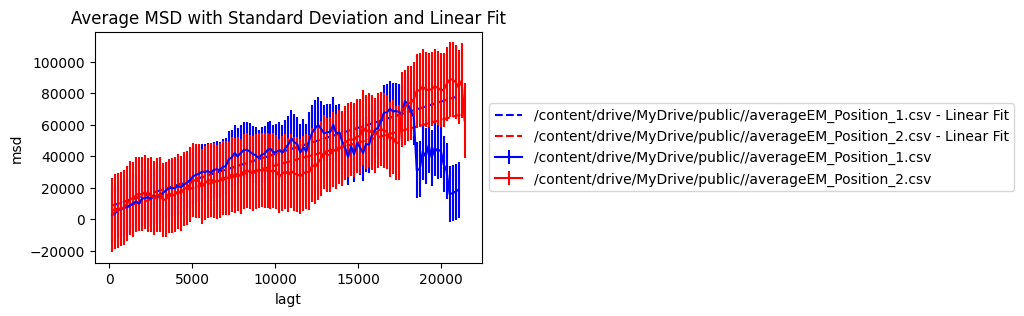

In [24]:
# import average MSD csv files and plot with Std and linear fit

average_MSD_files={
    'averageEM_Position1.csv':{"color": "blue"},
    'averageEM_Position2.csv':{"color": "purple"},
    'averageEM_Position3.csv':{"color": "red"},
    'averageEM_Position4.csv':{"color": "orange"},
    'averageEM_Position5.csv':{"color": "yellow"},
    'averageEM_Position6.csv':{"color": "green"}
    }
average_MSD_files={
    path+'/averageEM_Position_1.csv':{"color": "blue"},
    path+'/averageEM_Position_2.csv':{"color": "red"},
}


fittingRange=[0,100]
tc.doMSDFit(average_MSD_files, fittingRange=fittingRange)



<font color=red>NEED TO EDIT ONCE I HAVE THE low/high ATP JOBS </font>


### No ATP

Not sure how this naming scheme was decided upon

In [39]:
# former path
filenames_confinement = []
filenames_confinement.append(
    path+'/averageEM_Position_1.csv'
    )
diff_filenames = []
diff_filenames.append(
    path+'/diff_Position_1.csv'
    )
caseNames = ["-ATP" for x in range(len(filenames_confinement))]


### With ATP

In [40]:
# with atp?
filenames_confinement_ATP = []
filenames_confinement_ATP.append(
    path+'/averageEM_Position_2.csv'
    )
diff_filenames_ATP = []
diff_filenames_ATP.append(
    path+'/diff_Position_2.csv'
    )

caseNamesATP = ["+ATP" for x in range(len(filenames_confinement_ATP))]
#print(casesATP)

In [41]:
filenames_confinement =  filenames_confinement + filenames_confinement_ATP
diff_filenames =  diff_filenames + diff_filenames_ATP
caseNames = caseNames + caseNamesATP

In [42]:
print(filenames_confinement)

['/content/drive/MyDrive/public//averageEM_Position_1.csv', '/content/drive/MyDrive/public//averageEM_Position_2.csv']


### Load data
We used to load/process images here, but now we just use postprocessed data here (tracking happens elsewhere in notebook)

In [43]:
cases = dict()
class empty:pass

In [52]:
for i,filename in enumerate(filenames_confinement):

    # store data
    case = empty()

    #
    case.name = filenames_confinement[i]
    ar = pd.read_csv(filenames_confinement[i])
    print("Lag time isn't quite what we want")
    case.time1 = ar['lagt']
    case.dataavg1 = ar['msd']
    print("D is needed")
    ar = pd.read_csv(filename)
#    case.D = D
    ar = pd.read_csv(diff_filenames[i])
    case.dists = ar

    cases[caseNames[i]] = case


Lag time isn't quite what we want
D is needed
Lag time isn't quite what we want
D is needed


Text(0, 0.5, 'Prob')

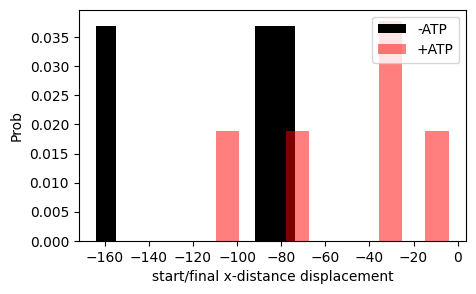

In [56]:
caseName='-ATP'
case = cases[caseName]
plt.hist(case.dists,density=True,color='black',label='-ATP')

caseName='+ATP'
case = cases[caseName]
plt.hist(case.dists,alpha=0.5,density=True,color='red',label='+ATP')
plt.legend(loc=0)
plt.xlabel("start/final x-distance displacement")
plt.ylabel("Prob")


* Tests
```
cd tests
```
* Run (kafka)
```
python3 ../brownian_v3.py -yamlFile expt.yaml -run
```
* Process
```
python3 batchProcess.py -single expt # kant for now
```
* upload expt.csv



In [62]:
sourcePath = "/content/cellmigration/"
simFile = sourcePath+"expt_analysis/expt.csv"
simData = np.loadtxt(simFile)

batchProcess.py    concentration.py	      LICENSE		     README_1.md
brownian_v2.py	   conda_openmm_pytraj.ipynb  master.ipynb	     README.md
brownian_v3.py	   config.bash		      migration_paper.ipynb  run
brownian_v4.py	   cont_analysis	      paper		     states.py
brownian_v5.py	   expt_analysis	      parameters.py	     TAM_example.ipynb
brown_util.py	   expt_analysis.ipynb	      pdb.py		     tests
brown_wnonbond.py  histo.ipynb		      processData.py	     update.py
calculator.py	   lattice.py		      processYaml.py	     validation.py


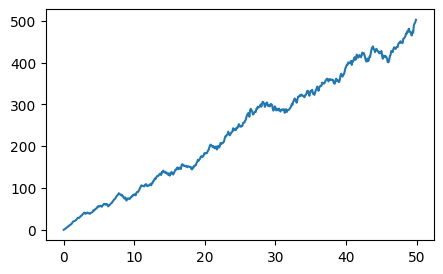

In [63]:
plt.plot(simData[:,0],simData[:,1])

<font color=red>Need to also load sim case where we measure displacements </font>

Not storing D right now until timescale is worked out


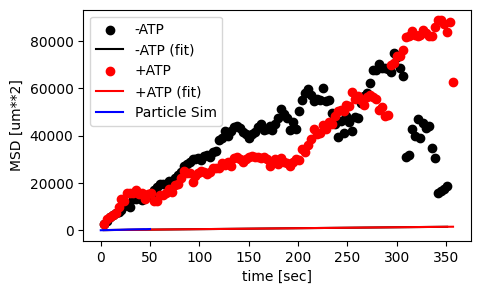

In [68]:
print("Not storing D right now until timescale is worked out")
sec_to_min = 60.
caseName = '-ATP'
case = cases[caseName]
t = case.time1/sec_to_min
plt.scatter(t,case.dataavg1,facecolor='k',label=caseName)
case.D = 1
msd = np.array(t)*4*case.D + 50
plt.plot(t, msd,'k',label=caseName+" (fit)")

caseName = '+ATP'
case = cases[caseName]
t = case.time1/sec_to_min
plt.scatter(t,case.dataavg1,facecolor='r',label=caseName)
case.D = 1
msd = np.array(t)*4*case.D + 50
plt.plot(t, msd,color='r',label=caseName+" (fit)")

# sims
plt.plot(simData[:,0],simData[:,1],color='b',label="Particle Sim")


plt.xlabel("time [min]")
plt.ylabel("MSD [um**2]")
plt.legend(loc=0)
plt.gcf().savefig("msd.png",dpi=300)

In [ ]:
msd[9]

206.09947014256585